In [35]:
import os
import cv2

import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16

import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14547430835316713310
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3061527348
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10591302412644282303
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
os.listdir('Data/Garuda_Hacks/dataset-resized/dataset-resized/')

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [3]:
len(os.listdir('Data/Garuda_Hacks/dataset-resized/dataset-resized/paper/'))

594

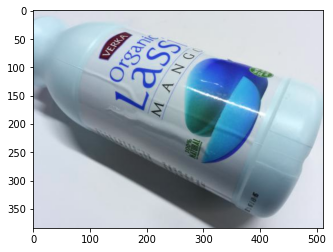

In [4]:
Img = cv2.imread('Data/Garuda_Hacks/dataset-resized/dataset-resized/plastic/plastic125.jpg')

plt.imshow(Img)

In [5]:
source_dir = 'Data/Garuda_Hacks/dataset-original/'

data_generator = ImageDataGenerator(rescale = 1./255. , validation_split = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    shear_range = 0.3,
#                     zoom_range = 0.3,
                    rotation_range = 30,
                    height_shift_range = 0.4,
                    width_shift_range = 0.4
                )

train_generator = data_generator.flow_from_directory(source_dir,
                                                    target_size = (224,224),
                                                    batch_size = 32,
                                                    subset = 'training',
                                                    class_mode = 'categorical',
                                                    shuffle = True)

valid_generator = data_generator.flow_from_directory(source_dir,
                                                    target_size = (224,224),
                                                    batch_size = 32,
                                                    subset = 'validation',
                                                    class_mode = 'categorical',
                                                    shuffle = True)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [7]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(224, 224, 3)))

In [8]:
len(basemodel.layers)

175

In [9]:
for layer in basemodel.layers[:20]:
    layer.trainable = False
for layer in basemodel.layers[20:]:
    layer.trainable = True

# headmodel = basemodel.output
# headmodel = MaxPooling2D()(headmodel)
# headmodel = Conv2D(3,kernel_size = (3,3), padding='same', activation= 'relu')(headmodel)
# headmodel = BatchNormalization()(headmodel)
# headmodel = Activation('relu')(headmodel)
# headmodel = Conv2D(3, 3,activation='softmax')(headmodel)
# headmodel = GlobalAveragePooling2D()(headmodel)
# headmodel = Dense(512, activation='relu')(headmodel)
# headmodel = Dense(256, activation='relu')(headmodel)
# headmodel = Dense(128, activation='relu')(headmodel)
# headmodel = BatchNormalization()(headmodel)
# headmodel = Dropout(0.4)(headmodel)
# headmodel = Dense(6, activation = 'sigmoid')(headmodel)

x = basemodel.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

model = Model(inputs = basemodel.input, outputs = x)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [27]:
model.compile(loss = 'mean_squared_error', optimizer=Adam(0.001), metrics= ["accuracy"])

In [28]:
def plt_lr(epoch_count):
    if epoch_count > 50:
        epoch_count = 50
    
    rng = [i for i in range(epoch_count)]

    plt.figure()
    y = [lrfn(x) for x in rng]
    plt.title(f'Learning rate schedule: {y[0]} to {y[epoch_count-1]}')
    plt.plot(rng, y)

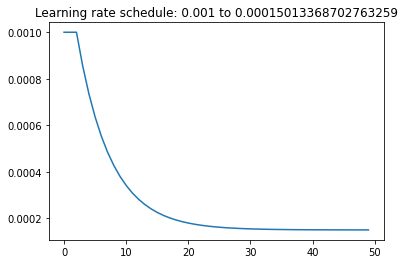

In [29]:
LR_START = 0.001
LR_MAX = 0.001
LR_MIN = 0.00015
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.83

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

plt_lr(75)

In [30]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss', factor=0.25, patience=5, verbose=1, mode='auto',
    min_delta=1e-10, cooldown=0, min_lr=0
)

checkpointer = ModelCheckpoint(filepath="resnet50_model_ghacks_weight.hdf5",monitor='val_loss', verbose=1, save_best_only=True)

In [6]:
history = model.fit(train_generator, epochs = 75, validation_data= valid_generator,callbacks=[checkpointer,reduce_learning_rate, earlystopping], verbose=1)

In [7]:
VGG_basemodel = VGG16(weights = 'imagenet', include_top = False, input_tensor=Input(shape=(224,224,3)))

In [8]:
len(VGG_basemodel.layers)

19

In [10]:
for layer in VGG_basemodel.layers[:15]:
    layer.trainable = False
for layer in VGG_basemodel.layers[15:]:
    layer.trainable = True
    
headmodel = VGG_basemodel.output
headmodel = GlobalAveragePooling2D()(headmodel)
headmodel = Dense(1024, activation='relu')(headmodel)
headmodel = BatchNormalization()(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(6, activation = 'sigmoid')(headmodel)

VGGmodel = Model(inputs = VGG_basemodel.input, outputs = headmodel)

In [43]:
model = Sequential()

model.add(Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))
model.add(Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(5,5))
model.add(Flatten())
model.add(Dense(180,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(6,activation='softmax'))

model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 222, 222, 200)     5600      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 220, 220, 180)     324180    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 44, 44, 180)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 42, 42, 180)       291780    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 40, 40, 140)       226940    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 38, 38, 100)       126100    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 36, 36, 50)       

In [11]:
VGGmodel.compile(loss = 'categorical_crossentropy', optimizer=Adam(0.0001), metrics= ["accuracy"])

In [39]:
def plt_lr(epoch_count):
    if epoch_count > 50:
        epoch_count = 50
    
    rng = [i for i in range(epoch_count)]

    plt.figure()
    y = [lrfn(x) for x in rng]
    plt.title(f'Learning rate schedule: {y[0]} to {y[epoch_count-1]}')
    plt.plot(rng, y)

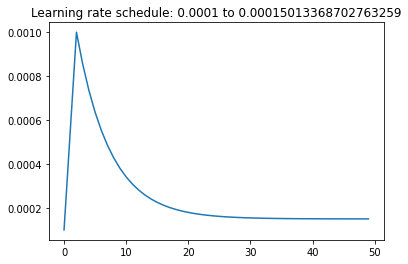

In [40]:
LR_START = 0.0001
LR_MAX = 0.001
LR_MIN = 0.00015
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = 0.83

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

plt_lr(100)

In [41]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss', factor=0.25, patience=5, verbose=1, mode='auto',
    min_delta=1e-10, cooldown=0, min_lr=0
)

checkpointer = ModelCheckpoint(filepath="cnn_model_ghacks_weight.hdf5",monitor='val_loss', verbose=1, save_best_only=True)

In [44]:
history = model.fit(train_generator, epochs = 100, validation_data= valid_generator,callbacks=[checkpointer,reduce_learning_rate, earlystopping],verbose=1)

Train for 64 steps, validate for 16 steps
Epoch 1/100
 1/64 [..............................] - ETA: 5:53:21WARNING:tensorflow:Can save best model only with val_loss available, skipping.


ResourceExhaustedError:  OOM when allocating tensor with shape[32,180,220,220] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node MaxPoolGrad_1 (defined at C:\Users\AwanKinton\anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_18330]

Function call stack:
distributed_function


In [18]:
def plt_acc(h):
    plt.figure()
    plt.plot(h.history["accuracy"])
    if 'val_accuracy' in h.history:
        plt.plot(h.history["val_accuracy"]) 
        plt.legend(["training","validation"])       
    else:
        plt.legend(["training"])
    plt.xlabel("epoch")
    plt.title("Sparse Categorical Accuracy")
    plt.show()

def plt_loss(h):
    plt.figure()
    plt.plot(h.history["loss"])
    if 'val_loss' in h.history:
        plt.plot(h.history["val_loss"]) 
        plt.legend(["training","validation"])       
    else:
        plt.legend(["training"])
    plt.legend(["training","validation"])
    plt.xlabel("epoch")
    plt.title("Loss")
    plt.show()

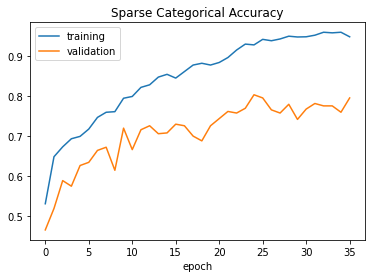

In [19]:
plt_acc(history)

In [20]:
VGGmodel.save('VGGmodel.h5')

model_json = VGGmodel.to_json()
with open('ghacks-vggmodel.json','w') as json_file:
    json_file.write(model_json)

In [21]:
with open('ghacks-vggmodel.json', 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('vgg_model_ghacks_weight.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [22]:
import numpy as np
def predict(jalan):
    img = image.load_img(path=jalan,grayscale=False,target_size=(224,224))
    plt.imshow(img)
    img = image.img_to_array(img)
    img = img/255.
    test_img = img.reshape(1,224,224,3)
    img_class = model.predict(test_img)
    print(img_class)
    label = np.argmax(img_class)
    return label

In [30]:
os.listdir('Data/Garuda_Hacks/dataset-original/')

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

[[7.3947161e-02 2.6196241e-02 9.9936002e-01 2.0462275e-04 1.9672129e-03
  9.9844520e-04]]


2

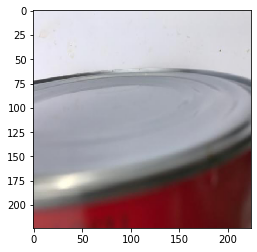

In [32]:
predict("Data/Garuda_Hacks/dataset-resized/dataset-resized/metal/metal1.jpg")

In [ ]:
# 0 cardboard
# 1 glass
# 2 metal
# 3 paper
# 4 plastic
# 5 trash

